In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import ast

In [27]:
character_metadata = pd.read_csv('./character.metadata.tsv', sep='\t', header=None)
movie_metadata = pd.read_csv('./movie.metadata.tsv', sep='\t', header=None)
name_clusters = pd.read_csv('./name.clusters.txt', sep='\t', header=None)
plot_summaries = pd.read_csv('./plot_summaries.txt', sep='\t', header=None)
tvtropes = pd.read_csv('./tvtropes.clusters.txt', sep='\t', header=None)

In [28]:
columns_movie_metadata = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name',
                          'Movie_release_date','Movie_box_office_revenue','Movie_runtime',
                          'Movie_languages','Movie_countries','Movie_genres']
columns_character_metadata =['Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date','Character_name',
                             'Actor_DOB','Actor_Gender','Actor_Height', 'Actor_Ethnicity', 'Actor_Name',
                            'Actor_Age_at_Movie_Release', 'Freebase_Character_Actor_Map_ID',
                            'Freebase_Character_ID', 'Freebase_Actor_ID'
]
movie_metadata.columns = columns_movie_metadata
character_metadata.columns = columns_character_metadata
plot_summaries.columns = ['Wikipedia_movie_ID', 'Plot_summary']

In [29]:
movie_metadata.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [30]:
character_metadata.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Character_Actor_Map_ID,Freebase_Character_ID,Freebase_Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [31]:
#Want to check how many of the characters appear in each movie

# Step 1: Merge dataframes on 'Wikipedia_movie_ID'
merged_df = character_metadata.merge(plot_summaries, on='Wikipedia_movie_ID', how='inner')
merged_df = merged_df.dropna(subset=['Character_name', 'Plot_summary'])

In [32]:
merged_df.groupby('Wikipedia_movie_ID')['Wikipedia_movie_ID'].count()

Wikipedia_movie_ID
3217        14
3746        15
3837        16
3947        15
4227         1
            ..
36814246     9
36956792    28
37373877     2
37478048     1
37501922     2
Name: Wikipedia_movie_ID, Length: 23068, dtype: int64

In [33]:
# Step 2 and Step 3: Count character name occurrences in movie descriptions
character_counts = []
for movie_id, group in merged_df.groupby('Wikipedia_movie_ID'):
    movie_description = group.iloc[0]['Plot_summary'] # movie description is the same for all rows in the group
    character_names = group['Character_name'].tolist()
    # Count how many character names appear in the movie description
    character_appearances = sum(1 for character in character_names if fuzz.partial_ratio(character, movie_description) >= 30)
    character_percentage = character_appearances/len(character_names)
    character_counts.append({
        'Wikipedia_movie_ID': movie_id,
        'Character_count_in_dataframe': len(character_names),
        'Character_percentage_in_description': character_percentage
    })


# Create a new dataframe with character counts for each movie
character_count_df = pd.DataFrame(character_counts)




C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


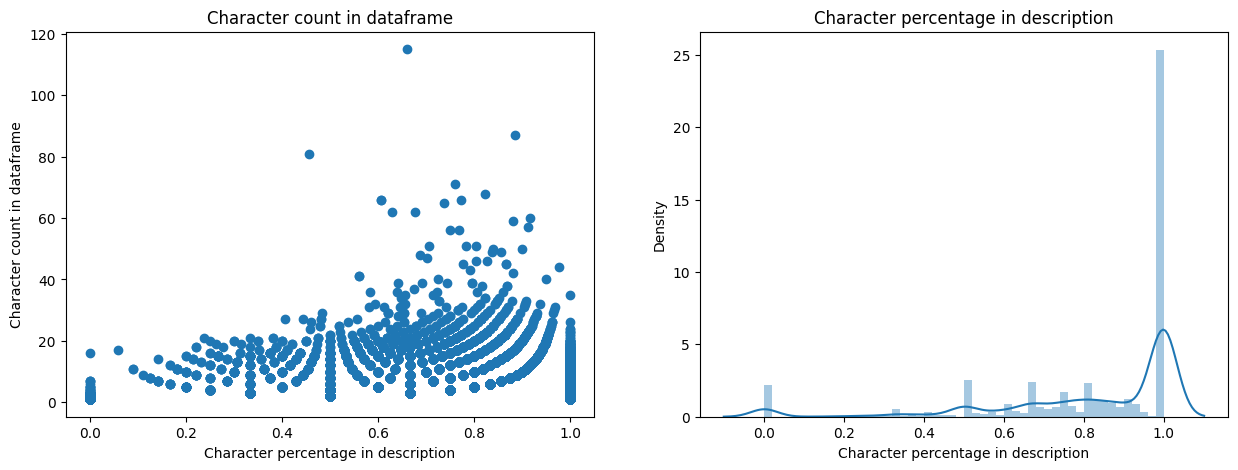

In [34]:
# Display the dataframe
figure, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(character_count_df['Character_percentage_in_description'], character_count_df['Character_count_in_dataframe'])
sns.distplot(character_count_df['Character_percentage_in_description'], ax=ax[1])
ax[0].set_xlabel('Character percentage in description')
ax[1].set_xlabel('Character percentage in description')
ax[0].set_ylabel('Character count in dataframe')
ax[1].set_ylabel('Density')
ax[0].set_title('Character count in dataframe')
ax[1].set_title('Character percentage in description')
plt.show()


In [35]:
no_character_description = character_count_df[character_count_df['Character_percentage_in_description'] == 0]
print(no_character_description)

       Wikipedia_movie_ID  Character_count_in_dataframe  \
21                   9429                             1   
289                 73467                             3   
296                 73930                             1   
403                 82390                             1   
585                144831                             1   
...                   ...                           ...   
23005            35987457                             1   
23011            36035782                             1   
23020            36089665                             1   
23030            36200448                             1   
23039            36353137                             1   

       Character_percentage_in_description  
21                                     0.0  
289                                    0.0  
296                                    0.0  
403                                    0.0  
585                                    0.0  
...                  

In [36]:
character_metadata[character_metadata['Wikipedia_movie_ID'] == 22727].head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Character_Actor_Map_ID,Freebase_Character_ID,Freebase_Actor_ID
118309,22727,/m/05plj,1991-09-27,Fukuhara Misuzu,1961-02-06,F,NaN,NaN,Yuko Kobayashi,30.0,/m/0ly_4s4,/m/0lzn5jd,/m/01vb92x
118310,22727,/m/05plj,1991-09-27,Satô Yuri,1966-01-05,F,NaN,NaN,Yuri Amano,25.0,/m/0ly_4pn,/m/0lzn5mc,/m/038cn3
118311,22727,/m/05plj,1991-09-27,Ueno Yoshiko,1964-09-25,F,NaN,NaN,Kikuko Inoue,27.0,/m/0ly_4nj,/m/0lzn5fy,/m/01nsyf
118312,22727,/m/05plj,1991-09-27,Inoue,1962-10-27,M,NaN,NaN,Junichi Kanemaru,28.0,/m/0ly_4q0,/m/0lzn5jt,/m/03zcy0
118313,22727,/m/05plj,1991-09-27,Miyoshi,1960-04-24,M,NaN,NaN,Masami Kikuchi,31.0,/m/0ly_4rz,/m/0lzn5gr,/m/0gnrlhw


In [37]:
# Convert the 'Movie_release_date' column to datetime
character_metadata['Movie_release_date'] = pd.to_datetime(character_metadata['Movie_release_date'], errors='coerce')

# Extract the year from the date
character_metadata['Year'] = character_metadata['Movie_release_date'].dt.year

# Group by 'Year' and 'Wikipedia_movie_ID' and count the number of characters
yearly_movie_character_counts = character_metadata.groupby(['Year', 'Wikipedia_movie_ID'])['Character_name'].count().reset_index()

# Group by 'Year' and calculate the average number of characters per movie for each year
average_characters_per_movie_per_year = yearly_movie_character_counts.groupby('Year')['Character_name'].mean()

# Print the result
print(average_characters_per_movie_per_year)

Year
1888.0    0.000000
1891.0    0.000000
1893.0    0.000000
1894.0    0.000000
1895.0    1.000000
            ...   
2012.0    4.848801
2013.0    4.083333
2014.0    1.300000
2015.0    3.000000
2016.0    5.000000
Name: Character_name, Length: 126, dtype: float64


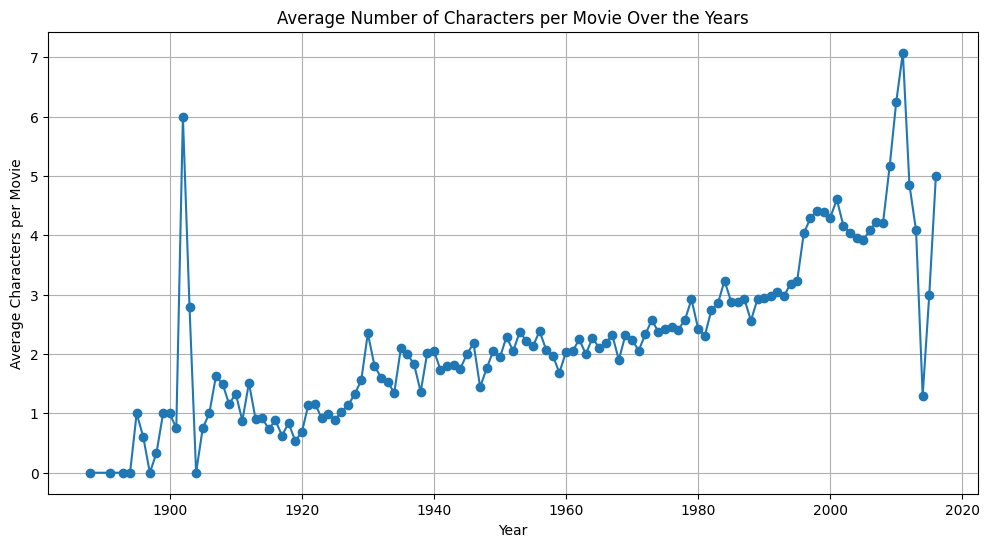

In [38]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(average_characters_per_movie_per_year.index, average_characters_per_movie_per_year.values, marker='o', linestyle='-')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Average Characters per Movie')
plt.title('Average Number of Characters per Movie Over the Years')

# Display the plot
plt.grid(True)
plt.show()

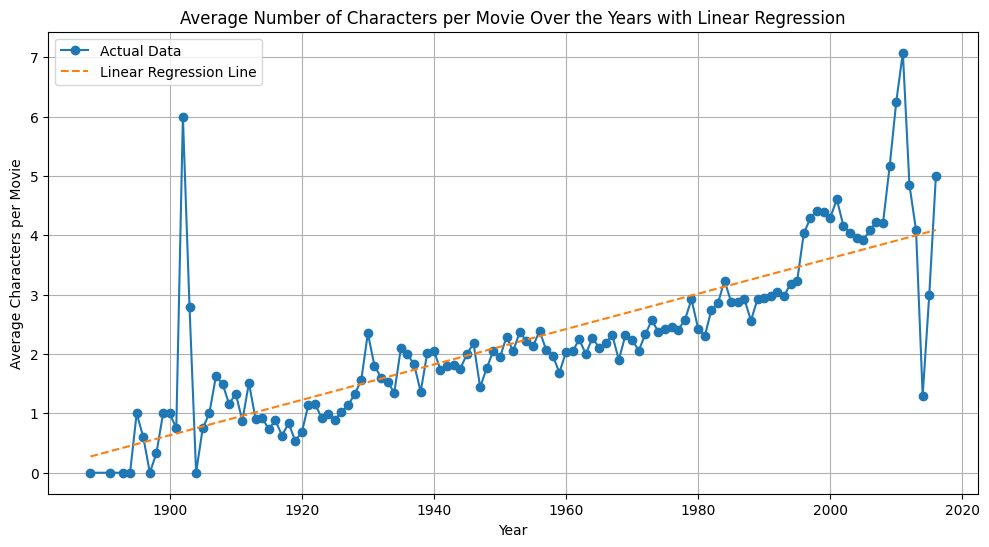

Linear Regression Coefficients:
Slope (Coefficient): 0.03
Intercept: -56.03
R-squared (R²): 0.65


In [39]:
years = average_characters_per_movie_per_year.index.values.reshape(-1, 1)
character_counts = average_characters_per_movie_per_year.values

# Create and fit a linear regression model
regression = LinearRegression()
regression.fit(years, character_counts)

# Make predictions using the linear model
predicted_character_counts = regression.predict(years)

# Create a line plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(years, character_counts, marker='o', linestyle='-', label='Actual Data')
plt.plot(years, predicted_character_counts, linestyle='--', label='Linear Regression Line')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Average Characters per Movie')
plt.title('Average Number of Characters per Movie Over the Years with Linear Regression')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

r_squared = r2_score(character_counts, predicted_character_counts)

# Print the linear regression coefficients
print("Linear Regression Coefficients:")
print(f"Slope (Coefficient): {regression.coef_[0]:.2f}")
print(f"Intercept: {regression.intercept_:.2f}")
# Print the R-squared value
print(f"R-squared (R²): {r_squared:.2f}")

In [43]:
# Convert the genre column from dictionary-like format to a list of genres
movie_metadata['Movie_genres2'] = movie_metadata['Movie_genres'].apply(lambda x: [genre.strip() for genre in ast.literal_eval(x).values()])

# Merge the 'character_metadata' and 'movie_metadata' dataframes using 'Wikipedia_movie_ID'
merged_movie_character = character_metadata.merge(movie_metadata, on='Wikipedia_movie_ID', how='inner')

# Group by genre and calculate the average number of characters per movie for each genre
genre_avg_characters = merged_movie_character.explode('Movie_genres2').groupby(['Movie_genres2', 'Wikipedia_movie_ID'])['Character_name'].count().reset_index()
average_characters_per_movie_per_genre = genre_avg_characters.groupby('Movie_genres2')['Character_name'].mean()

# Print the result
print(average_characters_per_movie_per_genre)

Movie_genres2
Absurdism           8.208791
Acid western        3.666667
Action              4.124464
Action Comedy       5.584337
Action Thrillers    4.898039
                      ...   
World History       0.000000
World cinema        3.015257
Wuxia               1.297521
Z movie             0.333333
Zombie Film         2.773946
Name: Character_name, Length: 360, dtype: float64


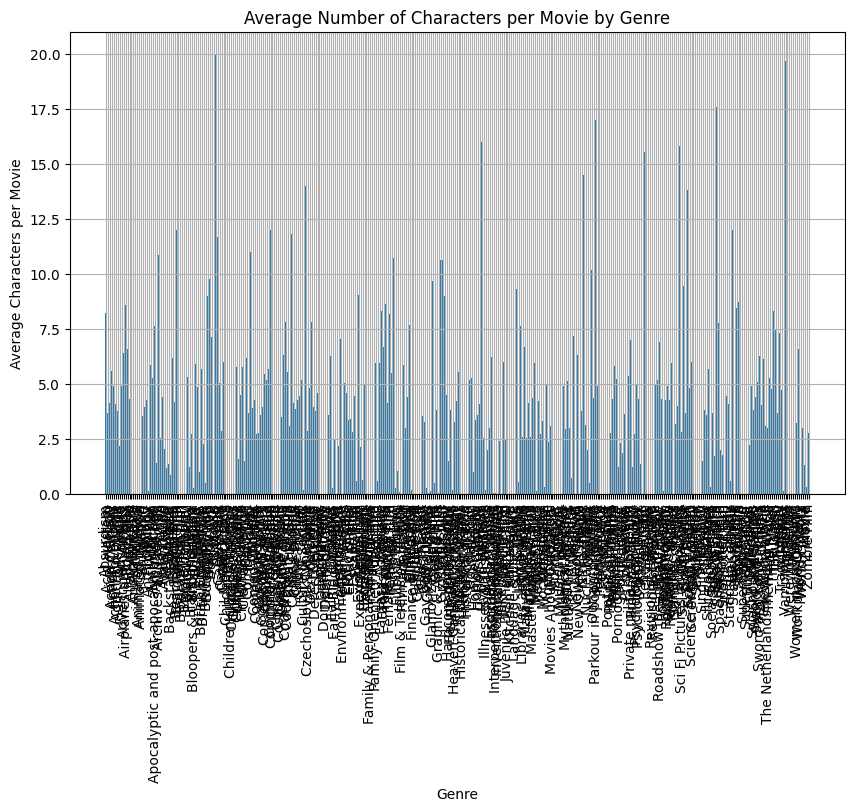

In [44]:
# Create a line plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(average_characters_per_movie_per_genre.index, average_characters_per_movie_per_genre.values)
# Set plot labels and title
plt.xlabel('Genre')
plt.ylabel('Average Characters per Movie')
plt.title('Average Number of Characters per Movie by Genre')
plt.xticks(rotation=90)
# Display the plot
plt.grid(True)
plt.show()